<a href="https://colab.research.google.com/github/Khulturg/Labs-IDA2025/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================================
# 1) Імпорт бібліотек
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='notebook')
%matplotlib inline


In [ ]:
# ----------------------------------------------------------
# 2) Завантаження датасету
# ----------------------------------------------------------
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
column_names = [
 'class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing',
 'gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring',
 'stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type',
 'veil-color','ring-number','ring-type','spore-print-color','population','habitat'
]

df = pd.read_csv(data_url, header=None, names=column_names)
print('Колонки:', df.columns.tolist())
print('Розмір датасету:', df.shape)
df.head()


Колонки: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
Розмір датасету: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [ ]:
# ----------------------------------------------------------
# 3) Обробка пропусків
# ----------------------------------------------------------
(df == '?').sum()

df.replace('?', np.nan, inplace=True)
print('Кількість пропусків:\n', df.isna().sum())

# Імпутація модою для stalk-root
mode_val = df['stalk-root'].mode()[0]
df['stalk-root'].fillna(mode_val, inplace=True)
print('Після імпутації пропусків залишилось:', df.isna().sum().sum())


Кількість пропусків:
 class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64
Після імпутації пропусків залишилось: 0


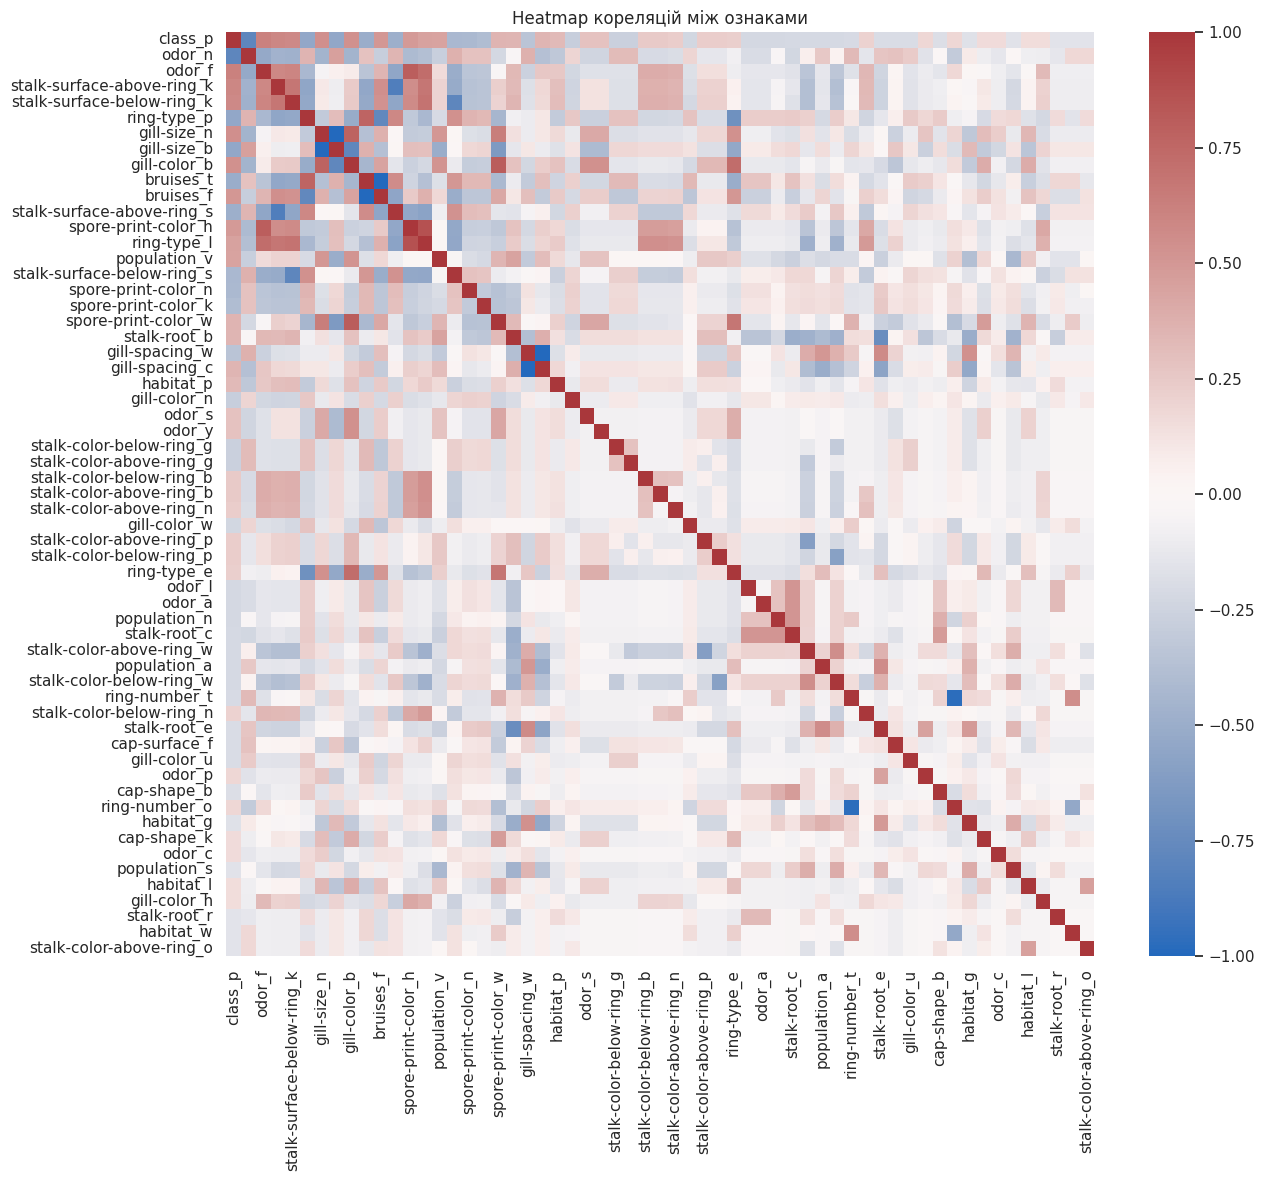

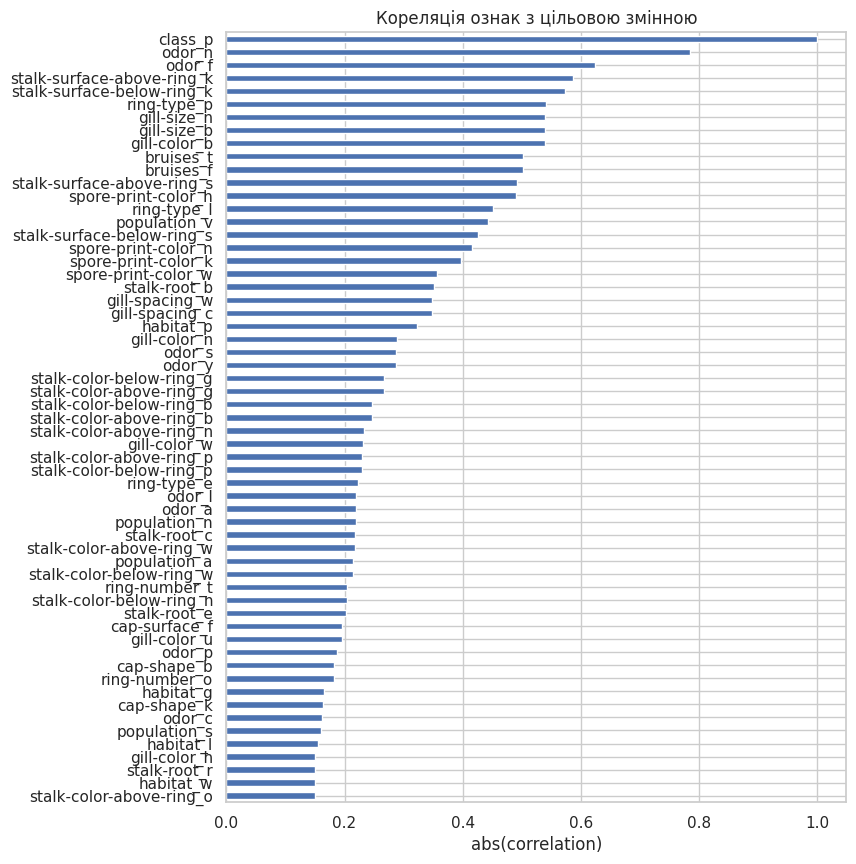

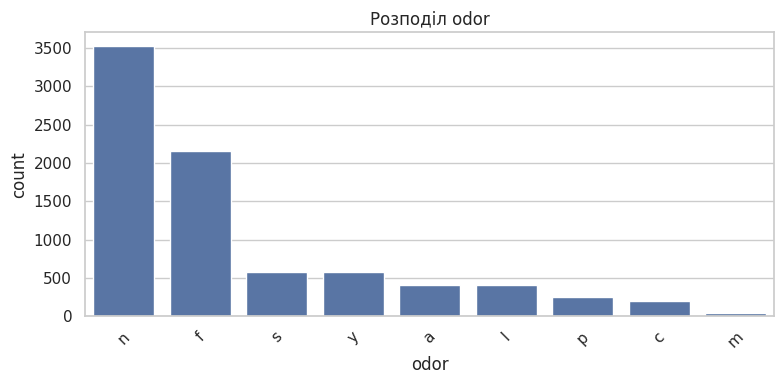

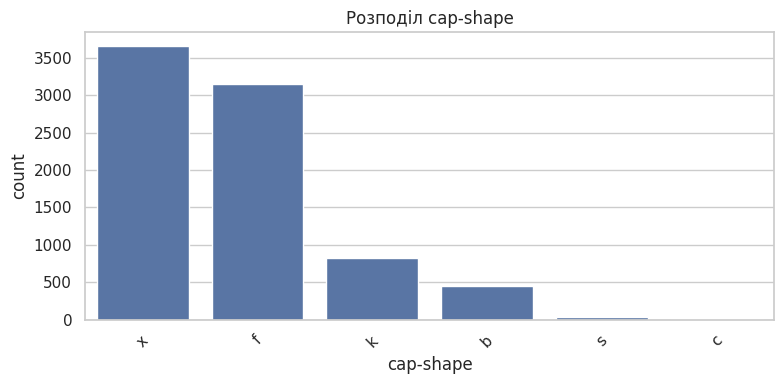

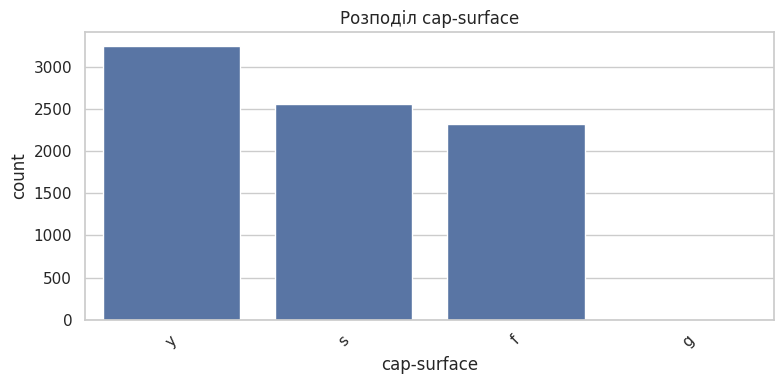

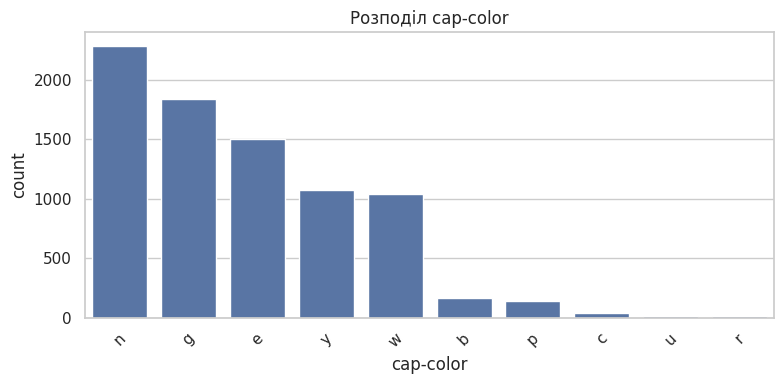

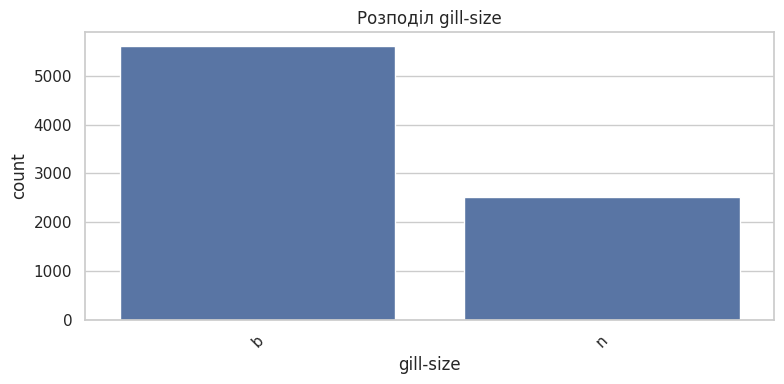

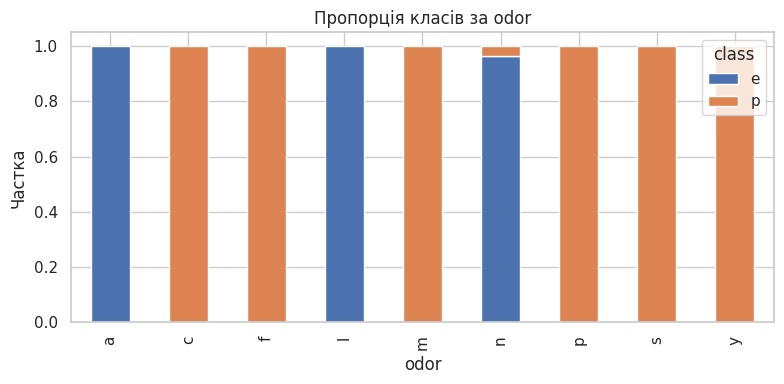

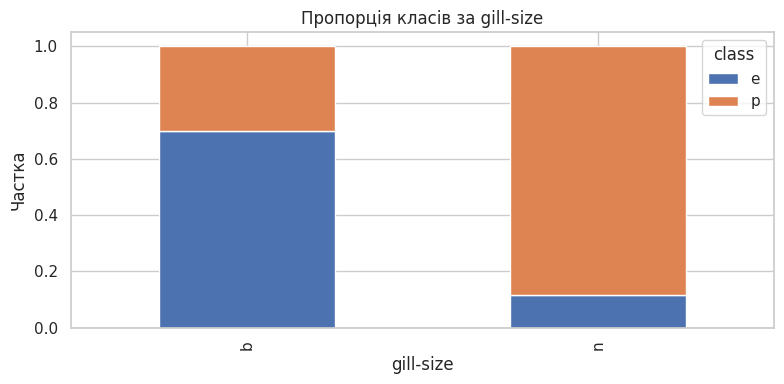

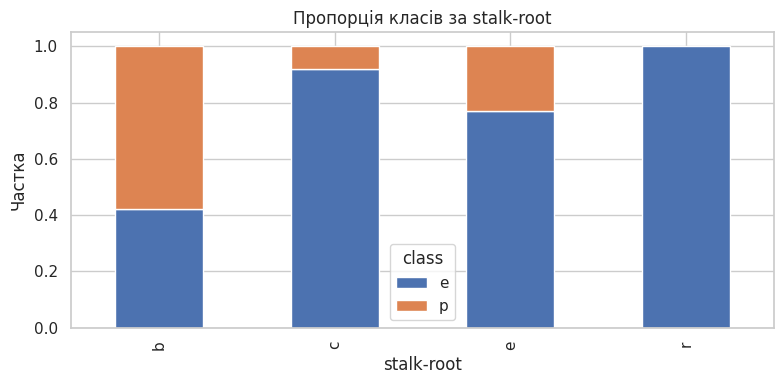

In [ ]:
# ----------------------------------------------------------
# 4) Візуалізації
# ----------------------------------------------------------
df_ohe = pd.get_dummies(df, drop_first=False)
corr = df_ohe.corr()
target = 'class_e' if 'class_e' in df_ohe.columns else [c for c in df_ohe.columns if c.startswith('class_')][0]
corr_with_target = corr[target].abs().sort_values(ascending=False)
top_features = corr_with_target.index[1:60]

plt.figure(figsize=(14,12))
sns.heatmap(df_ohe[top_features].corr(), cmap='vlag', center=0)
plt.title('Heatmap кореляцій між ознаками')
plt.show()

plt.figure(figsize=(8,10))
corr_with_target[top_features].sort_values().plot(kind='barh')
plt.title('Кореляція ознак з цільовою змінною')
plt.xlabel('abs(correlation)')
plt.show()

# Countplots
features_to_plot = ['odor','cap-shape','cap-surface','cap-color','gill-size']
for f in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=f, order=df[f].value_counts().index)
    plt.title(f'Розподіл {f}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Частка класів по категоріях
for f in ['odor','gill-size','stalk-root']:
    prop = pd.crosstab(df[f], df['class'], normalize='index')
    prop.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.title(f'Пропорція класів за {f}')
    plt.ylabel('Частка')
    plt.tight_layout()
    plt.show()


In [ ]:
# ----------------------------------------------------------
# 5) Нормалізація даних
# ----------------------------------------------------------
X = df.drop(columns=['class'])
y = df['class']
categorical_cols = X.columns.tolist()

preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
])
X_ohe = preprocessor.fit_transform(X)
print('Після OHE:', X_ohe.shape)

scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_ohe)
print('Після нормалізації:', X_scaled.shape)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
print('Train:', X_train.shape, 'Test:', X_test.shape)



Після OHE: (8124, 116)
Після нормалізації: (8124, 116)
Train: (6499, 116) Test: (1625, 116)


kNN params: {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}

=== kNN ===
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



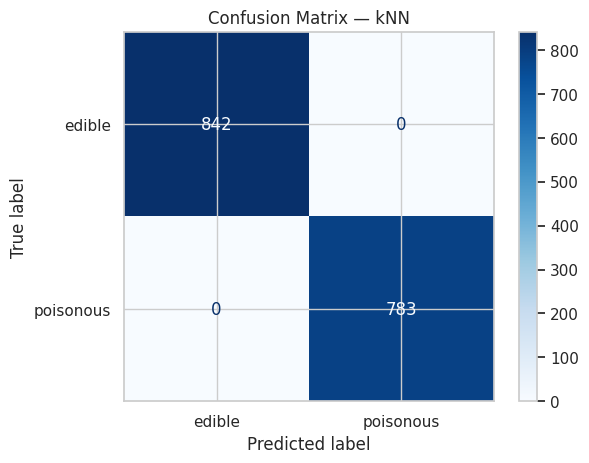

DT params: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}

=== Decision Tree ===
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



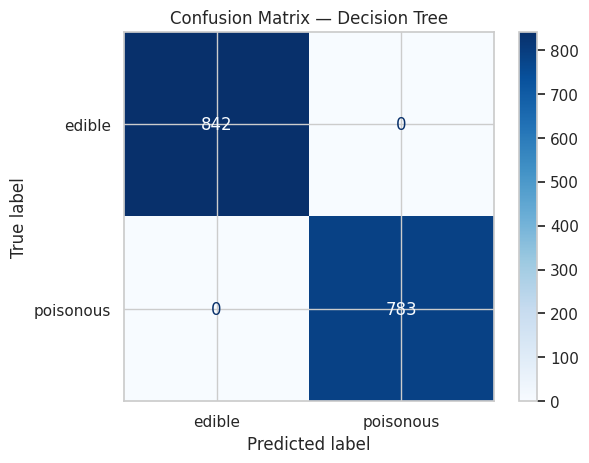

SVM params: {'C': 1, 'gamma': 'scale'}

=== SVM ===
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



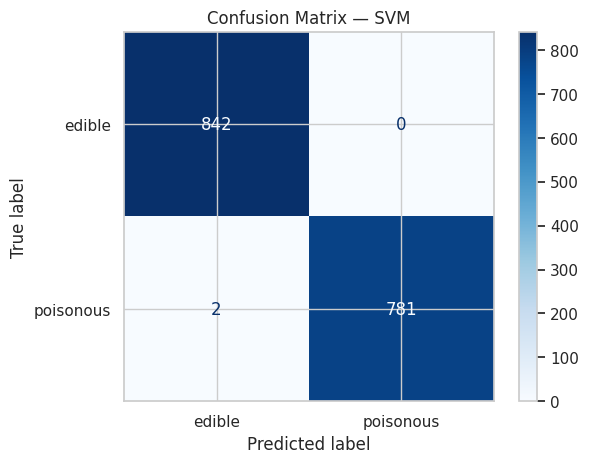

RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

=== Random Forest ===
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



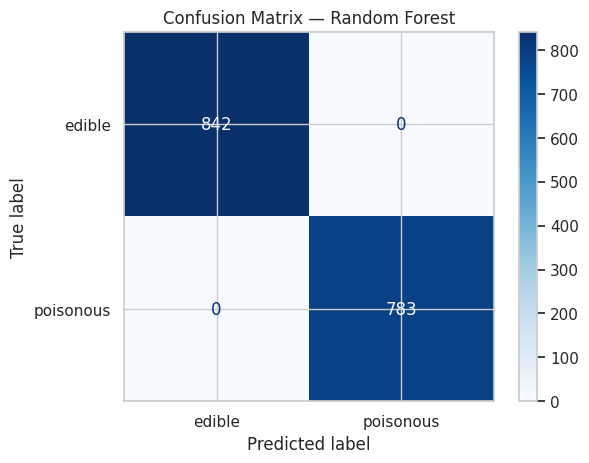

AdaBoost params: {'learning_rate': 1.0, 'n_estimators': 200}

=== AdaBoost ===
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



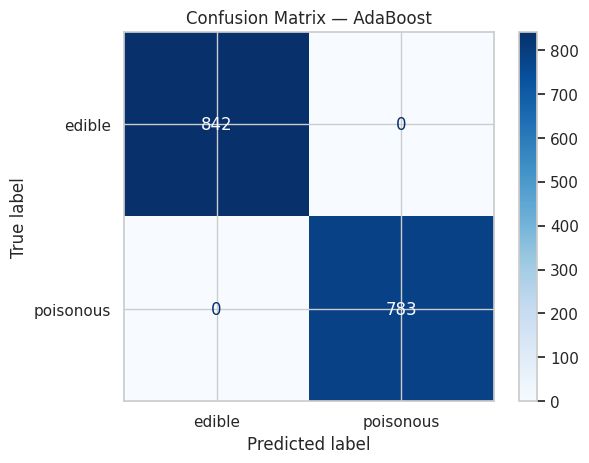

AdaBoostClassifier(n_estimators=200, random_state=42)

In [ ]:
# ----------------------------------------------------------
# 6) Навчання моделей
# ----------------------------------------------------------
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=['e','p'])
    ConfusionMatrixDisplay(cm, display_labels=['edible','poisonous']).plot(cmap='Blues')
    plt.title(f'Confusion Matrix — {name}')
    plt.show()
    return model

# ---------- kNN ----------
param_grid_knn = {
    'n_neighbors': [1,3,5,7,9],
    'weights': ['uniform','distance'],
    'p': [1,2]
}
gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, n_jobs=-1)
gs_knn.fit(X_train, y_train)
print('kNN params:', gs_knn.best_params_)
evaluate_model(gs_knn.best_estimator_, X_train, X_test, y_train, y_test, 'kNN')

# ---------- Decision Tree ----------
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2,5,10],
    'criterion': ['gini','entropy']
}
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, n_jobs=-1)
gs_dt.fit(X_train, y_train)
print('DT params:', gs_dt.best_params_)
evaluate_model(gs_dt.best_estimator_, X_train, X_test, y_train, y_test, 'Decision Tree')

# ---------- SVM ----------
param_grid_svm = {
    'C': [0.1,1,10,100],
    'gamma': ['scale','auto',0.01,0.1,1]
}
gs_svm = GridSearchCV(SVC(kernel='rbf'), param_grid_svm, cv=5, n_jobs=-1)
gs_svm.fit(X_train, y_train)
print('SVM params:', gs_svm.best_params_)
evaluate_model(gs_svm.best_estimator_, X_train, X_test, y_train, y_test, 'SVM')

# ---------- Random Forest ----------
param_grid_rf = {
    'n_estimators': [50,100,200],
    'max_depth': [None,10,20],
    'min_samples_split': [2,5]
}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, n_jobs=-1)
gs_rf.fit(X_train, y_train)
print('RF params:', gs_rf.best_params_)
evaluate_model(gs_rf.best_estimator_, X_train, X_test, y_train, y_test, 'Random Forest')

# ---------- AdaBoost ----------
param_grid_ada = {
    'n_estimators': [50,100,200],
    'learning_rate': [0.5,1.0,1.5]
}
gs_ada = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ada, cv=5, n_jobs=-1)
gs_ada.fit(X_train, y_train)
print('AdaBoost params:', gs_ada.best_params_)
evaluate_model(gs_ada.best_estimator_, X_train, X_test, y_train, y_test, 'AdaBoost')


In [ ]:
# ----------------------------------------------------------
# 7) Порівняння точностей
# ----------------------------------------------------------
scores = {
    'kNN': gs_knn.best_score_,
    'DecisionTree': gs_dt.best_score_,
    'SVM': gs_svm.best_score_,
    'RandomForest': gs_rf.best_score_,
    'AdaBoost': gs_ada.best_score_,
}
print("\n=== Порівняння середньої точності (CV) ===")
print(pd.Series(scores).sort_values(ascending=False))



=== Порівняння середньої точності (CV) ===
RandomForest    1.000000
kNN             0.999692
DecisionTree    0.999692
AdaBoost        0.999692
SVM             0.999538
dtype: float64
